# Uplaods & Imports

In [ ]:
!apt-get update && apt-get install swig cmake
!pip install box2d-py
!pip install "stable-baselines3[extra]>=2.0.0a4"

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,240 kB]
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,737 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [3,048 kB]
Get:14 h

In [ ]:
from gym.wrappers import RecordVideo
import os
import gymnasium as gym
import numpy as np
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import DQN
import matplotlib.pyplot as plt
from IPython.display import HTML, display
import re
import glob
from base64 import b64encode
from stable_baselines3.common.evaluation import evaluate_policy
import numpy as np
if not hasattr(np, "bool8"):
    np.bool8 = np.bool_
from gym.wrappers import RecordVideo
import os

#Functions

In [ ]:
def record_episode(model, step_tag):
    video_dir = f"./lander_videos_ep_{step_tag}"
    os.makedirs(video_dir, exist_ok=True)


    env = RecordVideo(
        gym.make("LunarLander-v3", render_mode="rgb_array"),
        video_folder=video_dir,
        name_prefix=f"lander_{step_tag}",
        episode_trigger=lambda ep: True
    )

    obs, _ = env.reset()
    done = False
    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)

    env.close()


In [ ]:
# For access to the current exploration rate
def get_epsilon(model):
    return model.exploration_schedule(model._current_progress_remaining)

In [ ]:
# Function to show one video
def show_video(path):
    mp4 = open(path, 'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return HTML(f'<video width=600 controls><source src="{data_url}" type="video/mp4">')

# Initialize

In [ ]:
# Create environment
env = gym.make("LunarLander-v3")
eval_env = gym.make("LunarLander-v3")  # separate env for evaluation


/usr/local/lib/python3.11/dist-packages/pygame/pkgdata.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_stream, resource_exists
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.11/dist-packages/pkg_resources/__init__.py:3154: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-pa

In [ ]:
# Initialize DQN Agent
model = DQN(
    "MlpPolicy",
    env,
    verbose=1,
    exploration_final_eps=0.1,
    target_update_interval=250,
)


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


# Training

In [ ]:
# Train in chunks: 10 × 100,000 = 1 million timesteps
rewards = []
epsilons = []


for step in range(10):
    print(f"🔁 Training chunk {step + 1}/10...")
    model.learn(total_timesteps=100_000, reset_num_timesteps=False)

    mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10)
    rewards.append(mean_reward)
    epsilons.append(get_epsilon(model))

    print(f"📈 Mean reward: {mean_reward:.2f} | Epsilon: {epsilons[-1]:.4f}")

    if step in [0, 1, 2, 4, 6, 9]:
      record_episode(model, step_tag=(step + 1) * 100_000)


🔁 Training chunk 1/10...
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 85.2     |
|    ep_rew_mean      | -86.3    |
|    exploration_rate | 0.969    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1336     |
|    time_elapsed     | 0        |
|    total_timesteps  | 341      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.63     |
|    n_updates        | 60       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 89.1     |
|    ep_rew_mean      | -189     |
|    exploration_rate | 0.936    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1073     |
|    time_elapsed     | 0        |
|    total_timesteps  | 713      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 3.95  

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


📈 Mean reward: 57.21 | Epsilon: 0.1000


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/lander_videos_ep_100000 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


🔁 Training chunk 2/10...
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 765      |
|    ep_rew_mean      | -45.7    |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 188      |
|    fps              | 761      |
|    time_elapsed     | 2        |
|    total_timesteps  | 102250   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.613    |
|    n_updates        | 25537    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 781      |
|    ep_rew_mean      | -30.8    |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 192      |
|    fps              | 770      |
|    time_elapsed     | 6        |
|    total_timesteps  | 104694   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.699 

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


📈 Mean reward: 2.03 | Epsilon: 0.1000


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/lander_videos_ep_200000 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


🔁 Training chunk 3/10...
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 387      |
|    ep_rew_mean      | -43.4    |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 544      |
|    fps              | 776      |
|    time_elapsed     | 3        |
|    total_timesteps  | 202552   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.484    |
|    n_updates        | 50612    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 416      |
|    ep_rew_mean      | -39.3    |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 548      |
|    fps              | 709      |
|    time_elapsed     | 8        |
|    total_timesteps  | 205940   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.434 

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


📈 Mean reward: -36.15 | Epsilon: 0.1000


/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/lander_videos_ep_300000 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


🔁 Training chunk 4/10...
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 328      |
|    ep_rew_mean      | -38.2    |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 892      |
|    fps              | 501      |
|    time_elapsed     | 1        |
|    total_timesteps  | 300802   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 7.31     |
|    n_updates        | 75175    |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 331      |
|    ep_rew_mean      | -38      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 896      |
|    fps              | 563      |
|    time_elapsed     | 2        |
|    total_timesteps  | 301652   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.851 

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


📈 Mean reward: 101.97 | Epsilon: 0.1000
🔁 Training chunk 5/10...
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 529      |
|    ep_rew_mean      | -3.68    |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 1084     |
|    fps              | 495      |
|    time_elapsed     | 0        |
|    total_timesteps  | 400319   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.318    |
|    n_updates        | 100054   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 539      |
|    ep_rew_mean      | -5.74    |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 1088     |
|    fps              | 602      |
|    time_elapsed     | 4        |
|    total_timesteps  | 402473   |
| train/              |          |
|    learning_rate    | 0

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/lander_videos_ep_500000 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


🔁 Training chunk 6/10...
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 962      |
|    ep_rew_mean      | -12.9    |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 1192     |
|    fps              | 699      |
|    time_elapsed     | 2        |
|    total_timesteps  | 502049   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 1.13     |
|    n_updates        | 125487   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 962      |
|    ep_rew_mean      | -12.2    |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 1196     |
|    fps              | 666      |
|    time_elapsed     | 9        |
|    total_timesteps  | 506049   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.583 

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


📈 Mean reward: 231.02 | Epsilon: 0.1000
🔁 Training chunk 7/10...
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 789      |
|    ep_rew_mean      | 163      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 1312     |
|    fps              | 555      |
|    time_elapsed     | 0        |
|    total_timesteps  | 600515   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.205    |
|    n_updates        | 150103   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 782      |
|    ep_rew_mean      | 166      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 1316     |
|    fps              | 688      |
|    time_elapsed     | 5        |
|    total_timesteps  | 603737   |
| train/              |          |
|    learning_rate    | 0

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/lander_videos_ep_700000 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


🔁 Training chunk 8/10...
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 618      |
|    ep_rew_mean      | 207      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 1468     |
|    fps              | 722      |
|    time_elapsed     | 1        |
|    total_timesteps  | 700949   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.162    |
|    n_updates        | 175212   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 609      |
|    ep_rew_mean      | 207      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 1472     |
|    fps              | 739      |
|    time_elapsed     | 4        |
|    total_timesteps  | 703088   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 10.1  

/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


📈 Mean reward: 189.85 | Epsilon: 0.1000
🔁 Training chunk 9/10...
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 623      |
|    ep_rew_mean      | 209      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 1632     |
|    fps              | 648      |
|    time_elapsed     | 3        |
|    total_timesteps  | 801955   |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.167    |
|    n_updates        | 200463   |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 625      |
|    ep_rew_mean      | 209      |
|    exploration_rate | 0.1      |
| time/               |          |
|    episodes         | 1636     |
|    fps              | 708      |
|    time_elapsed     | 6        |
|    total_timesteps  | 804760   |
| train/              |          |
|    learning_rate    | 0

/usr/local/lib/python3.11/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.11/dist-packages/gym/wrappers/record_video.py:78: UserWarning: WARN: Overwriting existing videos at /content/lander_videos_ep_1000000 folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [ ]:
model.save("dqn_lunarlander")
del model
model = DQN.load("dqn_lunarlander")

# Evaluation

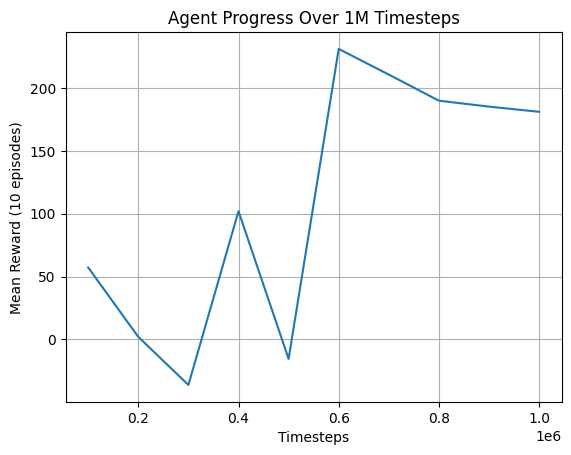

In [ ]:
# Plot reward trend
plt.plot([100_000 * (i + 1) for i in range(len(rewards))], rewards)
plt.title("Agent Progress Over 1M Timesteps")
plt.xlabel("Timesteps")
plt.ylabel("Mean Reward (10 episodes)")
plt.grid(True)
plt.show()


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


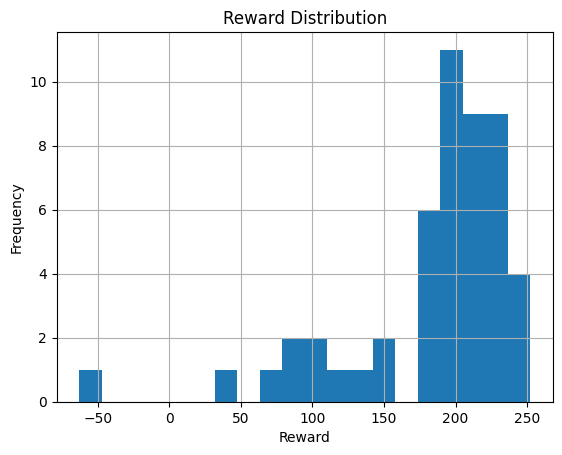

In [ ]:
# Sample raw rewards
rewards_raw = []
for _ in range(50):
    episode_reward, _ = evaluate_policy(model, eval_env, n_eval_episodes=1, return_episode_rewards=True)
    rewards_raw.extend(episode_reward)

plt.hist(rewards_raw, bins=20)
plt.title("Reward Distribution")
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


# 🎥 Watching Videos 🍿

In [ ]:
# Grab and sort all video paths by numeric step
video_paths = sorted(
    glob.glob("./lander_videos_ep_*/**/*.mp4", recursive=True),
    key=lambda x: int(re.search(r"ep_(\d+)", x).group(1))
)

# Display all videos
for path in video_paths:
    step = re.search(r"ep_(\d+)", path).group(1)
    print(f"🎯 Episode after {step} timesteps")
    display(show_video(path))



🎯 Episode after 100000 timesteps


🎯 Episode after 200000 timesteps


🎯 Episode after 300000 timesteps


🎯 Episode after 500000 timesteps


🎯 Episode after 700000 timesteps


🎯 Episode after 1000000 timesteps
